In [1]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

#references: https://link.springer.com/content/pdf/10.1007/s10751-005-9217-x.pdf?pdf=button

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 12.011 # Weight of C
Z = 6  # Number of protons in the ion (C)
Ne = 3 # Number of remaining electrons (Lithium-like)
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
c = 299792458.0 # m/s

q0=Z-Ne

mass0 = A*m_u + Ne*m_e # eV/c^2

beta_rel = 0.47
gamma_rel = 1.13

p0c = mass0*beta_rel*gamma_rel #eV/c

# equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
# gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

# p0c = equiv_proton_momentum*(Z-Ne) # eV/c
# gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
# beta = np.sqrt(1-1/(gamma*gamma)) # ion beta
print()

In [8]:
257.34*2

514.68

In [2]:
#https://www.sciencedirect.com/science/article/pii/0168583X87905830

circumference =  108.36#m
T = circumference/(c*beta_rel)
s_per_turn = T

beta_x = 5
beta_y = 5

disp_x = 0
Q_x = 2.2
Q_y = 2.4
dQx = 0
dQy = 0

arc = xt.LineSegmentMap(
        qx=Q_x, qy=Q_y,
        dqx=dQx, dqy=dQy,
        length=circumference,
        betx=beta_x,
        bety=beta_y
        )




In [3]:
emittance=1*1e-6 #inital emittance
num_particles = int(1e4)

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 2e-5 # relative ion momentum spread
sigma_p = 2e-4 # relative ion momentum spread

delta = np.random.normal(loc=0.0, scale=sigma_p, size=num_particles)
x = np.random.normal(loc=0.0, scale=sigma_x, size=num_particles) + disp_x * delta
px = np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y = np.random.normal(loc=0.0, scale=sigma_y, size=num_particles)
py = np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

particles = xp.Particles(
    mass0=mass0,
    p0c=p0c,
    q0=q0,
    x=x,
    px=px,
    y=y,
    py=py,
    delta=delta,
    zeta=0
)

In [4]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
# hw0 = 230.823 # eV
hc=constants.hbar*c/constants.e # eV*m (ħc)
lambda_0 = 154.82*1e-9 # m -- ion excitation wavelength
hw0 = 2*np.pi*hc/lambda_0 # m -- ion excitation wavelength
ion_excited_lifetime=3.8e-9

lambda_l = lambda_0*gamma_rel*(1 + beta_rel*np.cos(theta_l)) # m -- laser wavelength
lambda_l = lambda_l*(1+1.5e-3)
#lambda_l =  257.34*1e-9 #m
# Shift laser wavelength for fast longitudinal cooling:
#lambda_l = lambda_l*(1+1*sigma_p) # m

laser_frequency = c/lambda_l # Hz


print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 2.5*1.3e-3


laser_intensity=50000


GF_IP = xt.CWLaser(_buffer=buf,
                      laser_x=0,
                      laser_y=0,
                      laser_z=0,
                      
                      laser_direction_nx = 0,
                      laser_direction_ny = 0,
                      laser_direction_nz = -1,
                      laser_wavelength = lambda_l, # m
                      laser_waist_radius = laser_waist_radius, # m
                      laser_intensity=laser_intensity,
                      ion_excitation_energy = hw0, # eV
                      ion_excited_lifetime  = ion_excited_lifetime, # sec,
                          
   )
                          
##################
# Tracking #
##################
x, px, action_x,excited_list,delta_list,state_list= [], [], [], [], [],[]
num_turns = int(1e0)
save_interval=num_turns/100
# loop over turns
for i in tqdm(range(num_turns)):
    if i % save_interval ==0:
    
        x.append(particles.x)
        px.append(particles.px)

        state=particles.state.copy()
        state_list.append(state)

        excited=particles.state==2
        fraction_excitation = sum(excited)/len(excited)

        excited_list.append(excited)

        delta_xs = particles.delta.copy()
        delta_list.append(delta_xs)
    
    # track particle
    arc.track(particles)
    GF_IP.track(particles)

excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)
time = np.arange(0, num_turns, save_interval) * s_per_turn

Laser wavelength = 257.56 nm


  0%|          | 0/1 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


14b3f4ca2eae4cfa951067d956b16a7c.c: In function ‘CWLaser_track_local_particle’:
14b3f4ca2eae4cfa951067d956b16a7c.c:3522:9: warning: multi-line comment [-Wcomment]
         // double OmegaRabi = \
         ^
14b3f4ca2eae4cfa951067d956b16a7c.c:3531:16: warning: unused variable ‘OmegaRabiTau’ [-Wunused-variable]
         double OmegaRabiTau = OmegaRabi/(2.0*gamma); // in the ion rest frame
                ^~~~~~~~~~~~
14b3f4ca2eae4cfa951067d956b16a7c.c:3456:12: warning: unused variable ‘beta0’ [-Wunused-variable]
     double beta0  = sqrt(1.0 - 1.0/(gamma0*gamma0));
            ^~~~~
100%|██████████| 1/1 [00:05<00:00,  5.10s/it]

Done compiling ContextCpu kernels.


In [5]:
# np.savez('results/gsi_data.npz', x=x, px=px, y=y, py=py, delta=delta_list,
#  state=state_list, time=time,s_per_turn=s_per_turn,slip_factor=slip_factor)

<Figure size 640x480 with 0 Axes>

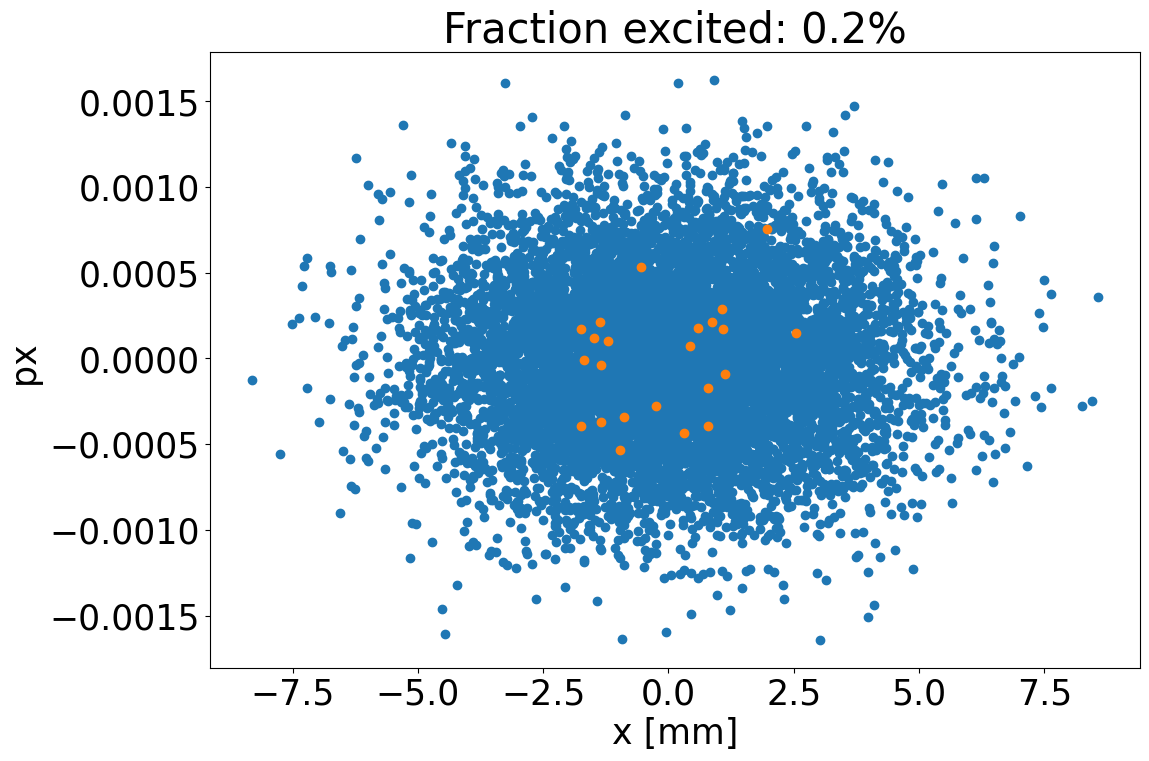

In [6]:
plt.figure()
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation*100, 1)}%')
#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3,particles.px)
plt.scatter(particles.x[excited]*1e3,particles.px[excited])
plt.xlabel('x [mm]')
plt.ylabel('px ')
plt.show()

<Figure size 640x480 with 0 Axes>

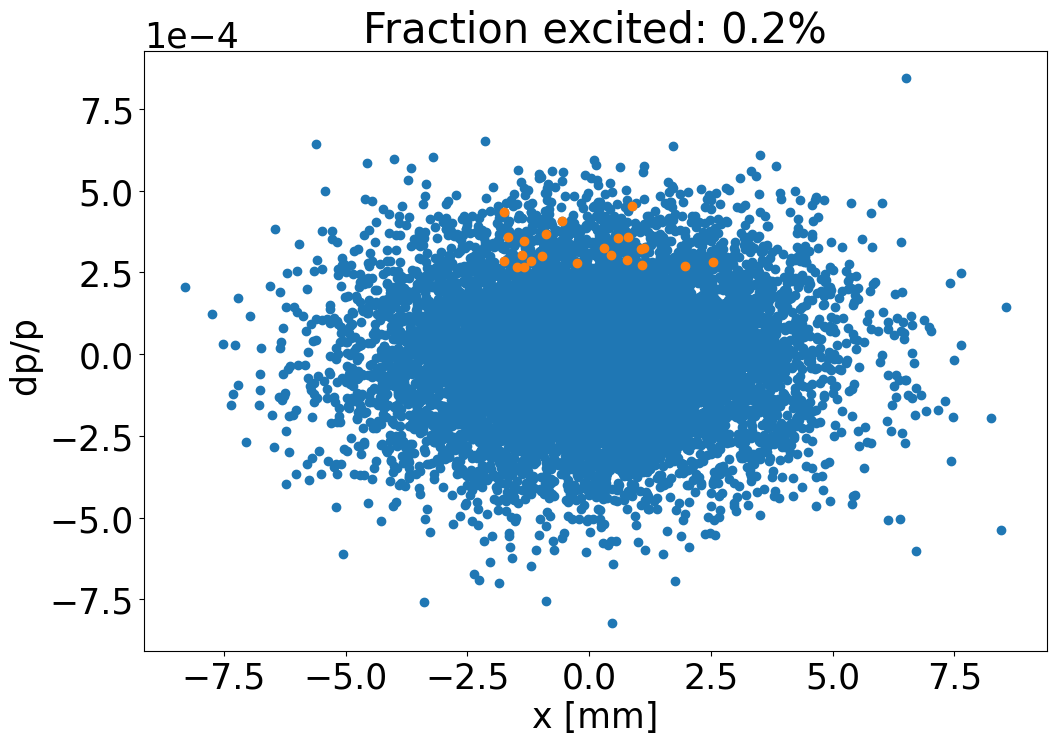

In [7]:
plt.figure()
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction excited: {round(fraction_excitation*100, 1)}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x*1e3,particles.delta)
plt.scatter(particles.x[excited]*1e3,particles.delta[excited])
plt.xlabel('x [mm]')
plt.ylabel('dp/p ')
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('First_turn.eps', format='eps', dpi=300)
plt.show()